In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 42.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#1. Generate ECFP4

In [5]:
# Load the input data
file_path = '/content/drive/MyDrive/Thiazole project/Data for Training Model/data_Ki_cleaned.csv'
data = pd.read_csv(file_path)

# Extract SMILES and target
smiles_column = 'Smiles'  # Adjust the column name if needed
target_column = 'pChEMBL Value'  # Adjust the column name if needed
smiles = data[smiles_column]
target = data[target_column]

#Generate 2048-bit fingerprints using RDKit
fingerprints = []
for smile in smiles:
    mol = Chem.MolFromSmiles(smile)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        fingerprints.append(np.array(fp))
    else:
        fingerprints.append(np.zeros(2048))  # Handle invalid SMILES strings

fingerprints = np.array(fingerprints)

# Convert fingerprints to a DataFrame
fingerprint_df = pd.DataFrame({'pChEMBL Value': target})
fingerprint_data = pd.DataFrame(fingerprints, columns=[f'FP_{i}' for i in range(2048)])
data = pd.concat([fingerprint_df, fingerprint_data], axis=1)


In [ ]:
target

,pChEMBL Value
0,7.330000
1,8.540000
2,8.190000
3,10.310000
4,9.960000
...,...
651,6.670000
652,10.346667
653,7.540000
654,9.820000


In [6]:
data = pd.read_csv('/content/drive/MyDrive/Thiazole project/Data for Training Model/ECPF4.csv')
data

,Smiles,pChEMBL Value,FP_0,FP_1,FP_2,FP_3,FP_4,FP_5,FP_6,FP_7,...,FP_2038,FP_2039,FP_2040,FP_2041,FP_2042,FP_2043,FP_2044,FP_2045,FP_2046,FP_2047
0,Brc1ccc(OC[C@@H]2C[C@H]3C[C@H]3N2)cn1.Cl,7.330000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Brc1cncc(OC[C@@H]2C[C@@H]3C[C@@H]3N2)c1.Cl,8.540000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Brc1cncc(OC[C@@H]2C[C@H]3C[C@H]3N2)c1.O=C(O)C(...,8.190000,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,C(#Cc1cncc(OC[C@@H]2CCN2)c1)c1ccccc1,10.310000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,C(#Cc1cncc(OC[C@H]2CCN2)c1)c1ccccc1,9.960000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651,c1cncc(OCCN2CCCC2)c1,6.670000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
652,c1cncc(OC[C@@H]2CCN2)c1,10.346667,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
653,c1cncc([C@@H]2CCCN2)c1,7.540000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
654,c1nc2cc3c(cc2[nH]1)C1CNCC3C1,9.820000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#2. Data Preprocessing

In [7]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import SGD
from torch.nn import BCELoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from torch.utils.data import TensorDataset

In [8]:
class Data_preprocess():
    """
    This class converts numerical activity values to binary values and splits the original dataset into training, validation, and test tensor d   datasets. Additionally, it creates a data loader for each of the split datasets.

    Input:
    ------
    file csv, activity threshold, activiy column's name, device (GPU or CPU), batch size

    Returns:
    --------
    Tensor splitted dataset, data loader
    """
    def __init__(self, path, y_name,threshold, col_drop, device, batch_size):
        self.path = path
        self.data = pd.read_csv(self.path)
        self.data = self.data.drop(col_drop,axis=1)
        self.Y_name = y_name
        self.device = device
        self.batch_size = batch_size
        self.threshold = threshold

    def target_bin(self,data):
        #Converting numerical values to binary values
        t1 = data[self.Y_name] < self.threshold
        data.loc[t1, self.Y_name] = 0
        t2 = data[self.Y_name] >= self.threshold
        data.loc[t2, self.Y_name] = 1
        data[self.Y_name] = data[self.Y_name].astype('int64')
        return data

    def create_dataloader(self,data):
        X = data.drop(data.columns[0],axis = 1)
        y = data[self.Y_name]


        #Split Data train, Data_test, Data_validation
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                                        random_state =42, stratify=y)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1,
                                                                        random_state =42, stratify=y_train)


        # change numpy to tensor gpu
        self.X_train = torch.tensor(X_train.values , device= self.device).float()
        self.X_val = torch.tensor(X_val.values , device= self.device).float()
        self.X_test = torch.tensor(X_test.values, device= self.device).float()

        self.y_train = torch.tensor(y_train.values , device=self.device).float()
        self.y_val = torch.tensor(y_val.values, device=self.device).float()
        self.y_test = torch.tensor(y_test.values, device=self.device).float()

        # convert into dataloader
        self.train_dataset = TensorDataset(self.X_train, self.y_train)
        self.val_dataset = TensorDataset(self.X_val, self.y_val)
        self.test_dataset = TensorDataset(self.X_test, self.y_test)

        self.train_loader = torch.utils.data.DataLoader(dataset=self.train_dataset,
                                                  batch_size=self.batch_size,
                                                  shuffle=True)
        self.valid_loader = torch.utils.data.DataLoader(dataset=self.val_dataset,
                                                  batch_size=self.batch_size,
                                                  shuffle=True)
        self.test_loader = torch.utils.data.DataLoader(dataset=self.test_dataset,
                                                  batch_size=self.batch_size,
                                                  shuffle=False)


    def fit(self):
        self.data_bin = self.target_bin(self.data)
        self.create_dataloader(self.data_bin)

In [9]:
#setting device
device = torch.device("cpu")

#Preprocessing data
preprocess = Data_preprocess(path = "/content/drive/MyDrive/Thiazole project/Data for Training Model/ECPF4.csv", y_name = "pChEMBL Value",
                             threshold = 7, col_drop = "Smiles",
                             device = device, batch_size = 32)
preprocess.fit()

#Getting train_loader
train_loader = preprocess.train_loader
valid_loader = preprocess.valid_loader
test_loader = preprocess.test_loader

#3. Training ANN model


In [10]:
class Net(torch.nn.Module):
    def __init__(self,params):
        super(Net,self).__init__()
        #n_layers
        self.n_layers_mlp = params["n_layers_mlp"]
        # dense_neurons
        self.dense_neurons = params["dense_neurons"]

        self.mlp_layers = torch.nn.ModuleList([])
        for i in range(self.n_layers_mlp):
            if i == 0:
                intput = params["in_features"]
                output = self.dense_neurons
            elif i != self.n_layers_mlp - 1:
                intput =  int(self.dense_neurons/(2**(i-1)))
                output = int(self.dense_neurons/(2**(i)))
            else:
                intput = int(self.dense_neurons/(2**(i-1)))
                output = 1
            self.mlp_layers.append(Linear(intput, output))

    def forward(self,x,params):
        rate = params["rate"]
        x = x.view(x.size(0), -1) # Flatten the input tensor for the first layer
        for i in range(self.n_layers_mlp):
            if i != self.n_layers_mlp-1:
                x = torch.relu(self.mlp_layers[i](x))
                x = F.dropout(x, p=rate, training=self.training)
            else:
                x =  torch.sigmoid(self.mlp_layers[i](x))

        return x

In [11]:
from sklearn.metrics import f1_score, average_precision_score, classification_report
import random
from sklearn.model_selection import RepeatedStratifiedKFold

In [12]:
class model_pipeline():
    '''
    This class contains a training pipeline including:training, evaluating and cross validation.
    Input:
    ------
    model architecture, data loader, optimizer, loss function, parameters for training model

    Returns:
    --------
    Trained model and training curve
    '''
    def __init__(self,model,params, criterion, optimizer,epochs,train_loader=None, valid_loader=None, seed=42, device=torch.device("cpu"),
                 save_dir=".", show_progress = True):
        self.device = device
        self.params = params
        self.model = model.to(self.device)
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.seed  = seed
        self.save_dir = save_dir
        self.epochs = epochs
        self.show_progress = show_progress
        self.seed_everything()

    def seed_everything(self):
        #Ensuring reproducible of training
        random.seed(self.seed)
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed_all(self.seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


    def train(self):
        #Training
        #self.seed_everything()
        self.model.train()
        trainning_loss = 0
        truelabels = []
        probas = []
        proba_flat = []
        pred_flat = []
        for fps, labels in self.train_loader:
            #Optimizer
            self.optimizer.zero_grad()
            output = self.model(fps, self.params)

            #Loss function
            loss = self.criterion(output[:,0], labels)
            loss.backward()
            self.optimizer.step()
            trainning_loss += loss.item()

            probas.append(np.asarray(output.detach().cpu()))
            a = list(np.asarray(labels.detach().cpu()))
            truelabels.append(a)


        #Flatten prediction array
        for i in probas:
            for j in i:
                proba_flat.append(j)

        pred_flat = proba_flat.copy()
        for key, value in enumerate(proba_flat):
            if value < 0.5:
                pred_flat[key] = 0
            else:
                pred_flat[key] = 1
        flatten_list = lambda truelabels:[element for item in truelabels for element in flatten_list(item)] if type(truelabels) is list else [truelabels]
        truelabels = flatten_list(truelabels)

        #Calculating loss, f1, average precision for training set
        loss = trainning_loss/len(self.train_loader)
        f1 = f1_score(truelabels,pred_flat)
        ap = average_precision_score(truelabels,proba_flat)
        return loss, f1, ap

    def evaluate(self):
        #Evaluate model
        self.model.eval()
        validation_loss = 0
        truelabels_val = []
        probas_val = []
        proba_flat_val = []
        pred_flat_val = []
        with torch.no_grad():
            for fps, labels in self.valid_loader:
                out_put = self.model(fps, self.params)
                validation_loss += self.criterion(out_put[:,0], labels).cpu()

                probas_val.append(np.asarray(out_put.detach().cpu()))
                a = list(np.asarray(labels.detach().cpu()))
                truelabels_val.append(a)

        #Flatten prediction
        for i in probas_val:
            for j in i:
                proba_flat_val.append(j)

        pred_flat_val = proba_flat_val.copy()
        for key, value in enumerate(proba_flat_val):
            if value < 0.5:
                pred_flat_val[key] = 0
            else:
                pred_flat_val[key] = 1


        flatten_list = lambda truelabels_val:[element for item in truelabels_val for element in flatten_list(item)] if type(truelabels_val) is list else [truelabels_val]
        truelabels_val = flatten_list(truelabels_val)

        #Calculation metrics: validation loss, f1 score and average precision
        loss_val = validation_loss/len(self.valid_loader)
        f1_val = f1_score(truelabels_val,pred_flat_val)
        ap_val = average_precision_score(truelabels_val,proba_flat_val)
        return loss_val, f1_val, ap_val


    def save_model(self):
        #Saving model into *pth file in provided saving directory
        print("Saving...")
        torch.save({
                'epoch': self.epochs,
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'loss': self.criterion,
                }, self.save_dir)

    def fit(self):
        self.seed_everything()
        self.history = {"train_loss":[], "val_loss": [],
              "train_f1":[], "val_f1":[],
              "train_ap":[], "val_ap":[]}
        for epoch in range(self.epochs):
            train1_loss, train1_f1, train1_ap = self.train()

            val1_loss,val1_f1, val1_ap = self.evaluate()

            #self.lr_scheduler.step(train1_f1)
            self.history["train_loss"].append(train1_loss)
            self.history["val_loss"].append(val1_loss.detach().numpy())
            self.history["train_f1"].append(train1_f1)
            self.history["val_f1"].append(val1_f1)
            self.history["train_ap"].append(train1_ap)
            self.history["val_ap"].append(val1_ap)
            if self.show_progress == True:
                if (epoch+1) % 5 == 0:
                    print("Epoch: {}/{}.. ".format(epoch+1, self.epochs),
              "Training Loss: {:.3f}.. ".format(train1_loss),
              "validation Loss: {:.3f}.. ".format(val1_loss),
            "validation f1_score: {:.3f}.. ".format(val1_f1),
                  "validation average precision: {:.3f}.. ".format(val1_ap),
             )
            else:
                pass


        if self.show_progress == True:
            self.visualize()
        else:
            pass
        self.save_model()
        print("Complete the process...")


    def visualize(self):
        sns.set()

        # create a subplot with three axes
        fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))


        ax1.plot(self.history["train_loss"], label='Training Loss')
        ax1.plot(self.history["val_loss"], label='Validation Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.set_title('Training and Validation Loss over Epochs')

        ax2.plot(self.history["train_f1"], label='Training F1 Score')
        ax2.plot(self.history["val_f1"],label="Validation F1 Score")
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('F1 score')
        ax2.legend()
        ax2.set_title('F1 Score over Epochs')

        ax3.plot(self.history["train_ap"], label='Training AP Score')
        ax3.plot(self.history["val_ap"],label="Validation AP Score")
        ax3.set_xlabel('Epochs')
        ax3.set_ylabel('Average precision score')
        ax3.legend()
        ax3.set_title('Average precision Score over Epochs')

        fig.suptitle('Training Metrics over Epochs')


        plt.show()

    def reset_weights(self,model):

        for layer in model.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()


    def cross_val_score(self, X, y,model, cv,batch_size, device,verbose = True):
        #Splitting original dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state =42, stratify=y)
        self.seed_everything()
        self.History = {"F1_record":[],"AP_record":[]}

        for i, (train_index, test_index) in enumerate(cv.split(X_train, y_train)):

            Xtrain = torch.tensor(X_train.iloc[train_index,:].values , device=self.device).float()
            Xtest = torch.tensor(X_train.iloc[test_index,:].values, device=self.device).float()

            ytrain = torch.tensor(y_train.iloc[train_index].values , device=self.device).float()
            ytest = torch.tensor(y_train.iloc[test_index].values, device=self.device).float()

            train_dataset = TensorDataset(Xtrain, ytrain)
            test_dataset = TensorDataset(Xtest, ytest)

            self.train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)
            self.valid_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False)
            #self.seed_everything()
            self.model = model.to(self.device)
            self.model.apply(lambda m: self.reset_weights(m))


            for epoch in range(self.epochs):
                train1_loss,train1_f1, train1_ap = self.train()
            val1_loss,val1_f1, val1_ap = self.evaluate()

            if verbose == True:
                print("Fold: {}.. ".format(i+1),
                "validation f1_score: {:.3f}.. ".format(val1_f1),
                      "validation average precision: {:.3f}.. ".format(val1_ap),
                 )
            else:
                pass
            self.History["F1_record"].append(val1_f1)
            self.History["AP_record"].append(val1_ap)

        self.mean_scores_ap = sum(self.History["AP_record"]) / len(self.History["AP_record"])
        print(f"Overall AP score = {self.mean_scores_ap :.4f}")
        self.mean_scores_f1 = sum(self.History["F1_record"]) / len(self.History["F1_record"])
        print(f"Overall F1 score = {self.mean_scores_f1:.4f}")

In [13]:
#Define model architecture
params ={"in_features" : 2048,
         "n_layers_mlp" : 2,
         "dense_neurons": 20,
         "rate": 0.5}

net = Net(params)

Epoch: 5/20..  Training Loss: 0.675..  validation Loss: 0.673..  validation f1_score: 0.278..  validation average precision: 0.852.. 
Epoch: 10/20..  Training Loss: 0.618..  validation Loss: 0.628..  validation f1_score: 0.862..  validation average precision: 0.868.. 
Epoch: 15/20..  Training Loss: 0.565..  validation Loss: 0.587..  validation f1_score: 0.848..  validation average precision: 0.885.. 
Epoch: 20/20..  Training Loss: 0.519..  validation Loss: 0.561..  validation f1_score: 0.853..  validation average precision: 0.897.. 


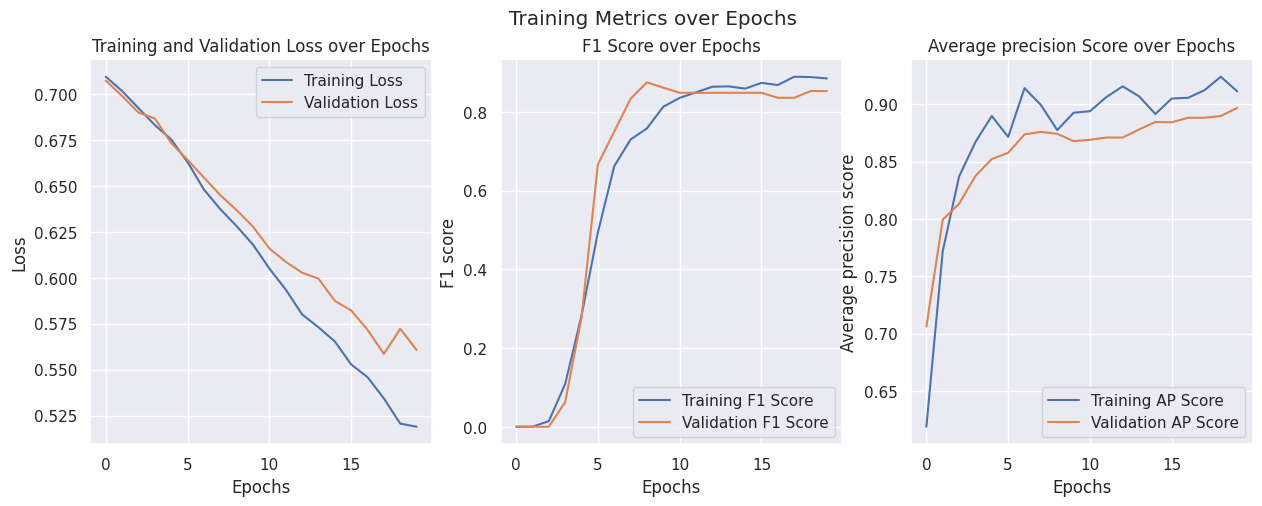

Saving...
Complete the process...


In [14]:
import os
#Training model
optimizer = torch.optim.Adam(net.parameters(), lr= 0.0001, weight_decay = 0.01)
criterion = torch.nn.BCELoss()
save_dir = "/content/drive/MyDrive/Thiazole project/ANN/ANN_model_baseline.pth"
#os.makedirs('/content/drive/MyDrive/Thiazole project/ANN', exist_ok=True)

pip = model_pipeline(model = net, params = params, criterion = criterion, optimizer = optimizer,
                    epochs =20, train_loader = train_loader, valid_loader = valid_loader,
                    seed = 42, device = device, save_dir  = save_dir,show_progress = True)
pip.fit()

#4. Model Validation

In [15]:
#Cross-Validation
from sklearn.model_selection import RepeatedStratifiedKFold

X = preprocess.data_bin.drop(preprocess.data_bin.columns[0],axis = 1)
y = preprocess.data_bin["pChEMBL Value"]
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3,random_state=42)

pip.cross_val_score(X=X, y=y, model = net,cv=cv, batch_size = 32, device = device)

Fold: 1..  validation f1_score: 0.836..  validation average precision: 0.922.. 
Fold: 2..  validation f1_score: 0.848..  validation average precision: 0.840.. 
Fold: 3..  validation f1_score: 0.812..  validation average precision: 0.873.. 
Fold: 4..  validation f1_score: 0.892..  validation average precision: 0.947.. 
Fold: 5..  validation f1_score: 0.857..  validation average precision: 0.924.. 
Fold: 6..  validation f1_score: 0.896..  validation average precision: 0.884.. 
Fold: 7..  validation f1_score: 0.831..  validation average precision: 0.933.. 
Fold: 8..  validation f1_score: 0.789..  validation average precision: 0.894.. 
Fold: 9..  validation f1_score: 0.873..  validation average precision: 0.976.. 
Fold: 10..  validation f1_score: 0.892..  validation average precision: 0.900.. 
Fold: 11..  validation f1_score: 0.824..  validation average precision: 0.914.. 
Fold: 12..  validation f1_score: 0.879..  validation average precision: 0.888.. 
Fold: 13..  validation f1_score: 0.81

In [16]:
#Saving baseline record
df_record_baseline = pd.DataFrame(pip.History)
df_record_baseline.to_csv("/content/drive/MyDrive/Thiazole project/ANN/ANN_cv_baseline.csv", index = False)

In [17]:
df_record_baseline.describe()

,F1_record,AP_record
count,30.000000,30.000000
mean,0.843268,0.911595
std,0.035555,0.040020
min,0.760563,0.813035
25%,0.818182,0.887951
50%,0.846778,0.918244
75%,0.872672,0.932994
max,0.895522,0.984429


In [18]:
import torch
import torch.nn as nn
from sklearn.metrics import f1_score, average_precision_score, classification_report

In [19]:
#External Validation
class external_validation():
    '''
    This class predict an unseen data loader using trained model.
    Input:
    ------
    Trained model, unseen data

    Returns:
    --------
    y_predict, probability
    '''
    def __init__(self,model, params, path, data_test,device):
        self.model = model
        self.save_dir = path
        self.data_test = data_test
        self.device = device
        self.params = params

    def predict(self):
        checkpoint = torch.load(self.save_dir)
        self.model = self.model.to(self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()
        #validation_loss = 0
        truelabels_val = []
        probas_val = []
        proba_flat_val = []
        pred_flat_val = []
        with torch.no_grad():
            for fps, labels in self.data_test:
                out_put = self.model(fps,self.params)
                #validation_loss += self.criterion(out_put[:,0], labels).cpu()

                a = list(np.asarray(labels.detach().cpu()))
                truelabels_val.append(a)

                probas_val.append(np.asarray(out_put.detach().cpu()))


        flatten_list = lambda truelabels_val:[element for item in truelabels_val for element in flatten_list(item)] if type(truelabels_val) is list else [truelabels_val]
        truelabels_val = flatten_list(truelabels_val)
        for i in probas_val:
            for j in i:
                proba_flat_val.append(j)

        pred_flat_val = proba_flat_val.copy()
        for key, value in enumerate(proba_flat_val):
            if value < 0.5:
                pred_flat_val[key] = 0
            else:
                pred_flat_val[key] = 1
        return pred_flat_val, truelabels_val

    def predict_proba(self):
        checkpoint = torch.load(self.save_dir)
        self.model = self.model.to(self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()
        #validation_loss = 0
        truelabels_val = []
        probas_val = []
        proba_flat_val = []
        with torch.no_grad():
            for fps, labels in self.data_test:
                out_put = self.model(fps, self.params)
                #validation_loss += self.criterion(out_put[:,0], labels).cpu()

                a = list(np.asarray(labels.detach().cpu()))
                truelabels_val.append(a)

                probas_val.append(np.asarray(out_put.detach().cpu()))

        flatten_list = lambda truelabels_val:[element for item in truelabels_val for element in flatten_list(item)] if type(truelabels_val) is list else [truelabels_val]
        truelabels_val = flatten_list(truelabels_val)
        for i in probas_val:
            for j in i:
                proba_flat_val.append(j)

        pred_flat_val = proba_flat_val.copy()
        for key, value in enumerate(proba_flat_val):
            if value < 0.5:
                pred_flat_val[key] = 0
            else:
                pred_flat_val[key] = 1
        return proba_flat_val,truelabels_val

In [20]:
from sklearn.metrics import f1_score, average_precision_score, classification_report
path = "/content/drive/MyDrive/Thiazole project/ANN/ANN_model_baseline.pth" #Directory contains trained model

external_val = external_validation(model = net,params = params,path = path,
                                   data_test = test_loader, device = device)


y_pre , y_true = external_val.predict()
y_proba, y_true = external_val.predict_proba()

#Classification report
print(classification_report(y_true, y_pre))

              precision    recall  f1-score   support

         0.0       0.84      0.80      0.82        54
         1.0       0.86      0.90      0.88        78

    accuracy                           0.86       132
   macro avg       0.85      0.85      0.85       132
weighted avg       0.86      0.86      0.86       132



<ipython-input-19-32af453375f1>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.save_dir)
<ipython-input-19-32af453375f1>:56: FutureWarning: Y

In [21]:
print(f1_score(y_true, y_pre))
print(average_precision_score(y_true, y_proba))

0.8805031446540881
0.907610480158692
